In [1]:
import requests
import json

In [2]:
street='Sint-Pietersvliet'
number='7'
post='2000'

In [3]:
polygone=[]

In [4]:
def house_info(street, number, post):
    a=requests.get('https://api.basisregisters.dev-vlaanderen.be/v1/adressen?'+'straatnaam='+street+'&huisnummer='+number+'&postcode='+post+'&limit=1')
    b=a.json()
    id1= b['adressen'][0]['identificator']['objectId']
    print('Id1 is',id1)
    c=requests.get('https://api.basisregisters.vlaanderen.be/v1/gebouweenheden?adresObjectId='+id1)
    d=c.json()
    id2= d['gebouweenheden'][0]['identificator']['objectId']
    print('Id2 is',id2)
    e=requests.get('https://api.basisregisters.vlaanderen.be/v1/gebouweenheden/'+id2)
    f=e.json()
    id3= f['gebouw']['objectId']
    print('Id3 is',id3)
    g=requests.get('https://api.basisregisters.vlaanderen.be/v1/gebouwen/'+id3)
    h=g.json()
    poly=h['geometriePolygoon']['polygon']['coordinates'][0]
    polygone.append(poly)

In [5]:
house_info(street, number, post)

Id1 is 1410900
Id2 is 16689264
Id3 is 16688047


In [6]:
#Part one
import rasterio as rio
import rioxarray as rxr
import pandas as pd


In [8]:
x=polygone[0][0][0]
y=polygone[0][0][1]


In [9]:
from files import dsm_df
from files import dtm_df

In [10]:
file_dsm_selected = dsm_df.loc[
    (x < dsm_df.xmax) & (x > dsm_df.xmin) & (y < dsm_df.ymax) & (y > dsm_df.ymin)
]

dsm_selected = file_dsm_selected.index.format()[0]


In [11]:
file_dtm_selected = dtm_df.loc[
    (x < dtm_df.xmax) & (x > dtm_df.xmin) & (y < dtm_df.ymax) & (y > dtm_df.ymin)
]
dtm_selected = file_dtm_selected.index.format()[0]

In [12]:
read_dsm = rxr.open_rasterio("DSM/" + dsm_selected, masked=True).squeeze()
read_dtm = rxr.open_rasterio("DTM/" + dtm_selected, masked=True).squeeze()

In [13]:
print("Is the spatial extent the same?", read_dsm.rio.bounds() == read_dtm.rio.bounds())

Is the spatial extent the same? True


In [14]:
k15=read_dsm - read_dtm

In [15]:
k15.rio.to_raster("k15.tif")

In [16]:
geometries = [
    {
        'type': 'Polygon',
        'coordinates': polygone
    }
]

In [18]:
clipped = rxr.open_rasterio("k15.tif", masked=True).rio.clip(geometries, from_disk=True)

In [78]:
clipped.rio.to_raster("clipped.tif")

(array([2.413e+03, 2.000e+00, 4.000e+00, 1.380e+02, 2.100e+01, 1.100e+01,
        1.000e+01, 1.680e+02, 5.200e+02, 6.550e+02]),
 array([ 0.        ,  4.03919477,  8.07838955, 12.11758432, 16.1567791 ,
        20.19597387, 24.23516865, 28.27436342, 32.3135582 , 36.35275297,
        40.39194775]),
 <BarContainer object of 10 artists>)

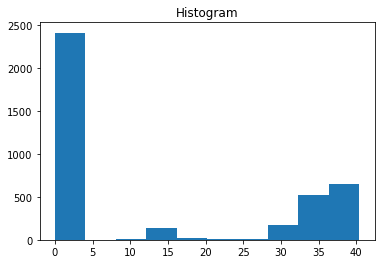

In [126]:
clipped.plot.hist()

In [129]:
from rasterio.windows import Window


In [130]:
with rio.open("clipped.tif") as img:
    chm = img.read(1, window=Window(0, 0, 512, 256))

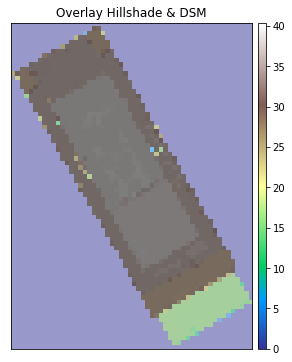

In [131]:
fig, ax = plt.subplots(figsize=(10, 6))
ep.plot_bands(
    chm, ax=ax, cmap="terrain", title="Overlay Hillshade & DSM",
)
ax.imshow(chm, cmap="Greys", alpha=0.5)
plt.show()


In [132]:
import geopandas as gpd

In [133]:
chm_gdp = gpd.GeoDataFrame(chm)


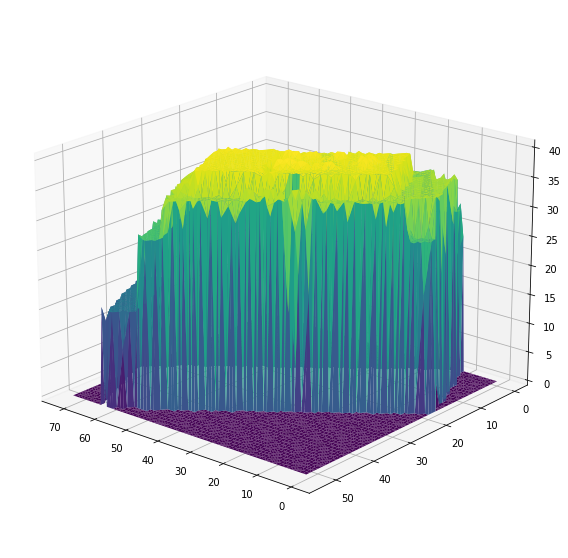

In [135]:
df = chm_gdp.unstack().reset_index()
df.columns = ["X", "Y", "Z"]
df["X"] = pd.Categorical(df["X"])
df["X"] = df["X"].cat.codes
fig = plt.figure(figsize=(35, 10))
ax = fig.gca(projection="3d")
ax.plot_trisurf(df["Y"], df["X"], df["Z"], cmap=plt.cm.viridis, linewidth=0.1)
ax.view_init(20, -230)
plt.show()